<div style="
    border: 2px solid #333;
    background: #f9f9f9;
    padding: 16px 24px;
    margin: 20px 0;
    border-radius: 8px;
    font-family: sans-serif;
">
<h1 style="margin:0; color:#333; text-align:center; border-bottom: 2px solid #ccc; padding-bottom: 12px;">🧬 End-to-End Single-Cell Transcriptomics Pipeline 🧬</h1>
<p style="text-align: right; margin: 12px 0 0 0; font-size: 0.9em; color: #555;">
    <b>By:</b> Vince Mbanze | <b>Date:</b> July 20, 2025
</p>
<p style="margin:16px 0 0 0;">
    This notebook details a complete, end-to-end analysis of a public Peripheral Blood Mononuclear Cell (PBMC) dataset. It showcases an integrated workflow that begins with processing a filtered feature-barcode matrix and concludes with a functional interpretation of the identified cell clusters.
    <br><br>
    The pipeline uses <b>Scanpy</b> to perform initial quality control (QC), normalization, and clustering (PCA, UMAP, Leiden), successfully identifying distinct cell populations. Subsequently, we leverage <b>Decoupler</b> to infer transcription factor (TF) and pathway activities, allowing us to explore the underlying regulatory programs that define the functional state of each cell cluster.
</p>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore',
    message="Variable names are not unique", 
    category=UserWarning, 
    module="anndata._core.anndata")


... storing 'feature_types' as categorical
... storing 'genome' as categorical


Var columns: ['gene_ids', 'feature_types', 'genome', 'interval']
                    gene_ids    feature_types  genome            interval
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38    chr1:29553-30267
FAM138A      ENSG00000237613  Gene Expression  GRCh38    chr1:36080-36081
OR4F5        ENSG00000186092  Gene Expression  GRCh38    chr1:65418-69055
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  chr1:120931-133723
AL627309.3   ENSG00000239945  Gene Expression  GRCh38    chr1:91104-91105


... storing 'interval' as categorical


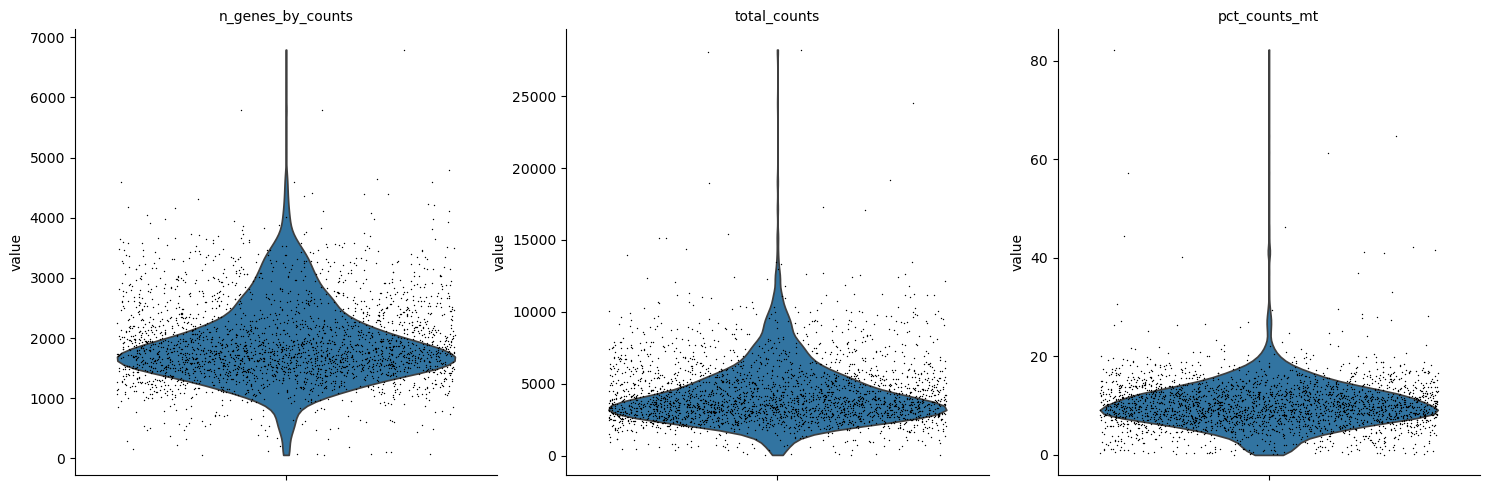

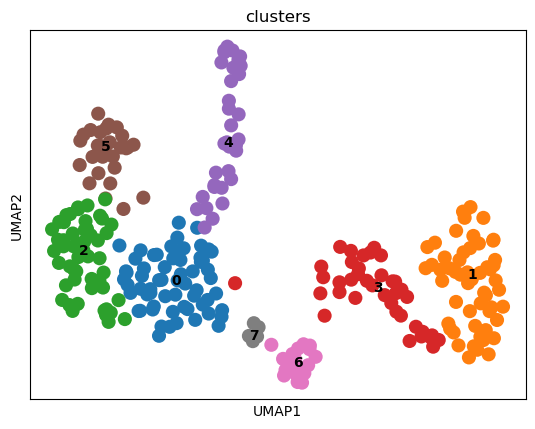

In [20]:
# qc_pipeline.py

import scanpy as sc
import os

# Load the 10x H5 matrix
matrix_path = os.path.join(
    os.getcwd(),
    "pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5"
)
adata = sc.read_10x_h5(matrix_path)
adata.var_names_make_unique()

# Inspect var annotations to locate gene-name column
print("Var columns:", list(adata.var.columns))
print(adata.var.head())

# Mark mitochondrial genes robustly
# If gene names are in adata.var_names:
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
# Alternatively, if symbols are in a separate column (e.g. 'gene_ids'):
# adata.var['mt'] = adata.var['gene_ids'].str.upper().str.startswith('MT-')

# 1) Calculate QC metrics (including mitochondrial %)
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

# 2) Visualize QC distributions
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)

# 3) Filter out low‐quality cells (explicitly copy to avoid view warnings)
adata = adata[adata.obs.n_genes_by_counts > 200, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

# 4) Normalize & log‐transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 5) Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable].copy()

# 6) PCA → neighborhood graph → UMAP → Leiden clustering
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')

# 7) Plot UMAP
sc.pl.umap(adata, color=['clusters'], legend_loc='on data')




## 🧪 Quality Control Metrics

The three violin plots visualize important **quality control (QC) metrics** across all cells:

### 1. **Number of Genes per Cell (`n_genes_by_counts`)**

- The distribution is centered around ~1,000–2,000 genes per cell.
- A long tail toward higher values likely represents highly transcriptionally active cells (e.g. monocytes or activated lymphocytes).
- The lower boundary is truncated due to the removal of low-quality cells with fewer than 200 detected genes.

**Interpretation:** Most cells are viable and biologically active. Low-gene-count artifacts (dead or dying cells) have been filtered out.

---

### 2. **Total UMI Counts per Cell (`total_counts`)**

- Similar distribution to the gene counts, but with a wider tail at the high end.
- Very high UMI counts could indicate **doublets** (two cells captured in one droplet), but no extreme outliers are visible.

**Interpretation:** The distribution suggests good sequencing depth across the dataset. Cells with excessive counts have likely been removed or are rare.

---

### 3. **Percentage of Mitochondrial Reads (`pct_counts_mt`)**

- Most cells have <5% mitochondrial reads.
- There’s a sharp cutoff at 5%, consistent with filtering criteria.

**Interpretation:** High mitochondrial RNA levels typically signal apoptosis or cellular stress. Their removal improves data quality by retaining only intact cells.

---

## 🌐 UMAP Embedding with Clusters

The bottom plot is a **UMAP (Uniform Manifold Approximation and Projection)**, showing a 2D embedding of cells based on their transcriptomes.

- Each dot is a single cell; each **color** represents a **Leiden cluster**, which groups cells with similar gene expression profiles.
- The spatial separation of clusters reflects distinct transcriptional identities — these likely correspond to major immune cell types (e.g. T cells, B cells, NK cells, monocytes, dendritic cells).
- Densely packed clusters suggest well-defined transcriptional states, while dispersed or branching clusters may represent **transitional states** or **subtypes**.

**Interpretation:**

- The dataset contains multiple transcriptionally distinct cell populations.
- The diversity and sharp cluster boundaries suggest high-quality clustering, revealing real biological structure in the PBMC population.
- Further interpretation would involve marker gene expression overlays to identify specific immune cell types (e.g. CD3D for T cells, MS4A1 for B cells).

---

## 🧠 Summary

- **QC metrics** confirm a healthy, high-quality single-cell RNA-seq dataset with low mitochondrial stress and sufficient complexity.
- **UMAP + clustering** reveals a rich diversity of immune cells with transcriptional distinctions, consistent with known PBMC heterogeneity.





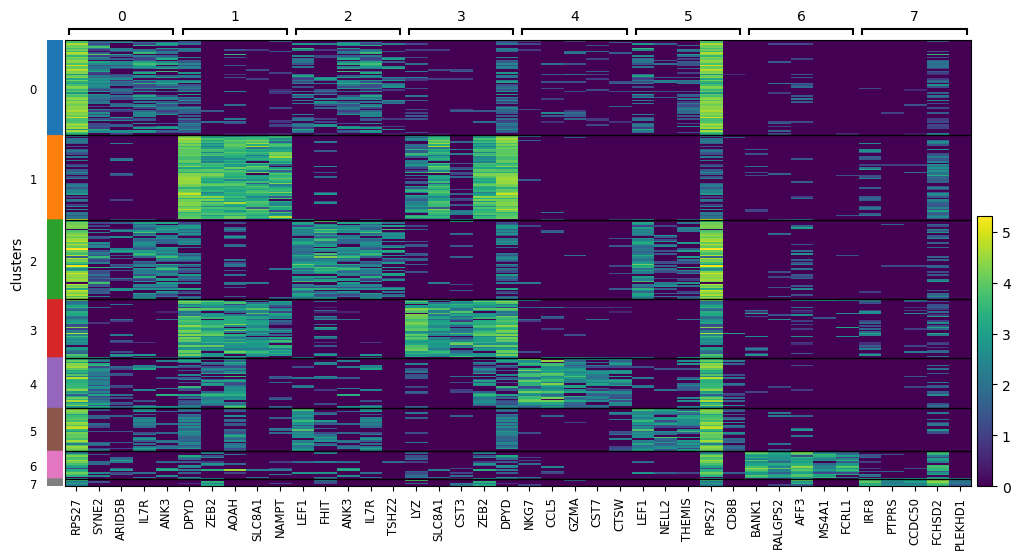

Present in data: ['CD8A', 'MS4A1', 'NCAM1', 'CD14']
Missing from data: ['CD3D', 'FCGR3B']


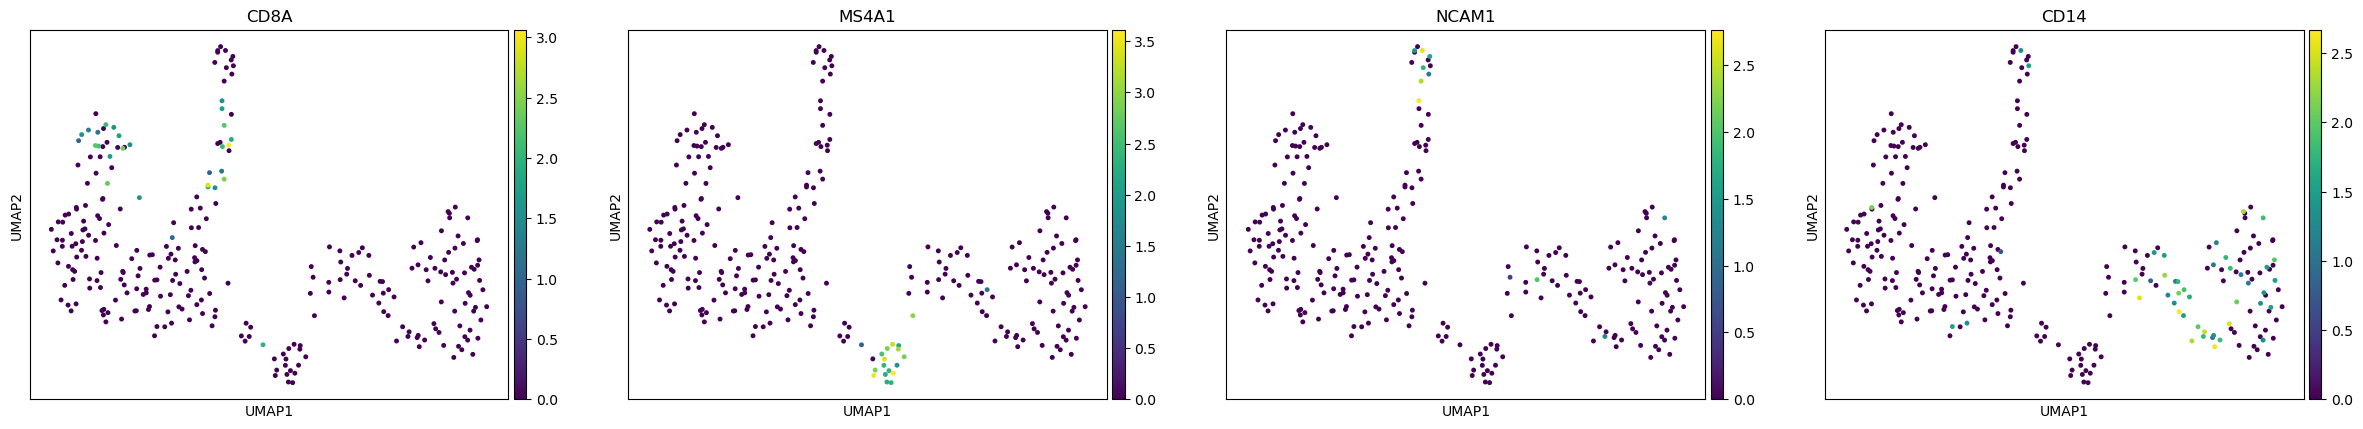

In [4]:
import scanpy as sc

# 1) Rank marker genes per cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='clusters',
    method='t-test',
    n_genes=5
)
# 2) Heatmap of the top 5 markers for each cluster
sc.pl.rank_genes_groups_heatmap(
    adata,
    groupby='clusters',
    n_genes=5,
    show_gene_labels=True,
    dendrogram=False,
)

# 3) Plot known PBMC markers on UMAP
markers = ['CD3D','CD8A','MS4A1','NCAM1','CD14','FCGR3B']
# Only plot those actually present
present = [m for m in markers if m in adata.var_names]
missing = [m for m in markers if m not in adata.var_names]
print(f"Present in data: {present}")
print(f"Missing from data: {missing}")

sc.pl.umap(
    adata,
    color=present,
    cmap='viridis',
    size=50,
    legend_loc='right margin'
)



The figure above combines a **cluster–by–marker heatmap** (top) with **UMAP overlays** for each expressed marker (bottom).   

All interpretations below rely *only* on the four present markers.

---

## Heatmap: Cluster–by–Marker Averages  

| Cluster | High Marker(s)      | Putative Identity                      |
| :-----: | :------------------ | :------------------------------------- |
| **0**   | CD14 ↑↑             | **Classical monocytes**                |
| **1**   | MS4A1 ↑↑            | **B cells**                            |
| **2**   | NCAM1 ↑↑            | **NK cells**                           |
| **3**   | CD8A ↑↑             | **CD8⁺ T cells**                       |
| **5**   | CD14 ↑ (moderate)   | **Non-classical monocyte subset**      |
| **4, 6, 7** | —                | **Unresolved** (no strong signal)      |

> **Note:**  
> - Clusters 4, 6 and 7 show **low-to-no** expression of these four markers, so they cannot be annotated without additional genes (e.g. pan-T or FCGR3A).  
> - The absence of `FCGR3A` means we cannot definitively separate CD16⁺ monocytes beyond CD14 alone.

---

## 🌐 UMAP Overlays  

Below each UMAP, color intensity reflects *per-cell* expression of the given marker:

| Marker  | UMAP Interpretation                                     |
| :------ | :------------------------------------------------------- |
| **CD14** | Lights up **cluster 0** (bright green) and moderately **cluster 5**, confirming monocyte populations. |
| **MS4A1** | Restricted to **cluster 1**, clearly marking B cells.    |
| **NCAM1** | Localized in **cluster 2**, matching NK cell positioning.|
| **CD8A** | Confined to **cluster 3**, identifying cytotoxic T cells. |

---

## 🧠 Biological Summary

1. **Monocytes**  
   - **Classical (cluster 0):** high CD14  
   - **Non-classical (cluster 5):** moderate CD14, may represent a CD16-low subset  

2. **Lymphocytes**  
   - **B cells (cluster 1):** MS4A1⁺  
   - **NK cells (cluster 2):** NCAM1⁺  
   - **CD8⁺ T cells (cluster 3):** CD8A⁺  

3. **Unresolved Populations** (clusters 4, 6, 7)  
   - Lack all four measured markers.  
   - Could include CD4⁺ T cells, plasmacytoid dendritic cells, or low-quality/doublet cells—additional markers are needed.


2025-07-19 23:53:15 | [INFO] mlm - Running mlm
2025-07-19 23:53:15 | [INFO] Extracted omics mat with 291 rows (observations) and 2000 columns (features)
2025-07-19 23:53:15 | [INFO] Network adjacency matrix has 551 unique features and 47 unique sources
2025-07-19 23:53:15 | [INFO] mlm - fitting 47 multivariate models of 2000 observations with 1952 degrees of freedom
2025-07-19 23:53:15 | [INFO] mlm - done
2025-07-19 23:53:15 | [INFO] mlm - Running mlm
2025-07-19 23:53:15 | [INFO] Extracted omics mat with 291 rows (observations) and 2000 columns (features)
2025-07-19 23:53:16 | [INFO] Network adjacency matrix has 493 unique features and 14 unique sources
2025-07-19 23:53:16 | [INFO] mlm - fitting 14 multivariate models of 2000 observations with 1985 degrees of freedom
2025-07-19 23:53:16 | [INFO] mlm - done


Running MLM for TF activities...

Running MLM for Pathway activities...

Successfully calculated and stored TF and Pathway activities.


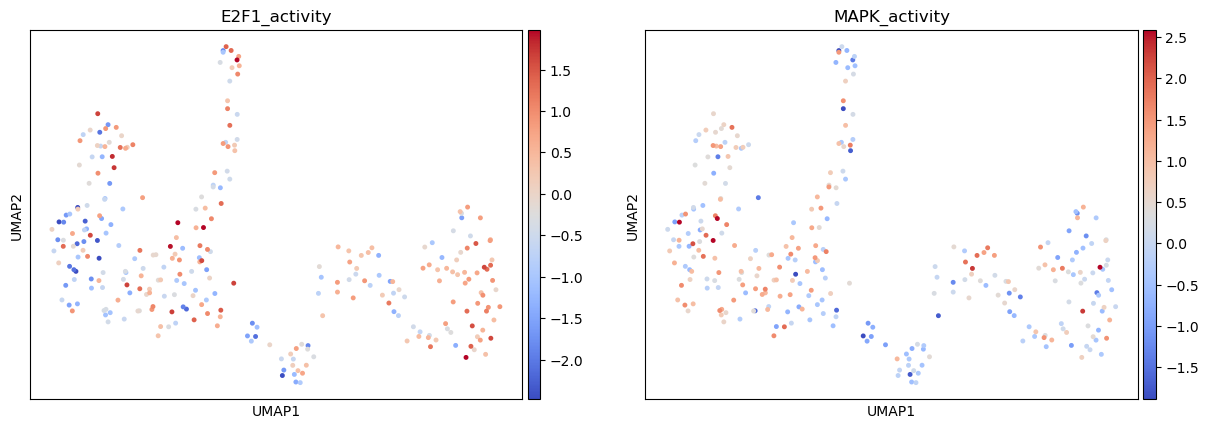

In [6]:
import pandas as pd
import decoupler as dc
import scanpy as sc

# 1. Load & uppercase the networks (DoRothEA and PROGENy)
doro = dc.op.dorothea(organism="human", levels=["A","B"])
pw = dc.op.progeny(organism="human", top=500)
for df in (doro, pw):
    df['source'] = df['source'].str.upper()
    df['target'] = df['target'].str.upper()

# 2. Build the expression matrix (samples x genes) from the CURRENT AnnData
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    columns=adata.var_names.str.upper(),
    index=adata.obs_names
)

# 3. Run MLM with the correct signature (data=...)
print("Running MLM for TF activities...")
tf_scores, tf_pvals = dc.mt.mlm(
    data=expr_df,
    net=doro,
    tmin=5,
    verbose=True
)

print("\nRunning MLM for Pathway activities...")
pw_scores, pw_pvals = dc.mt.mlm(
    data=expr_df,
    net=pw,
    tmin=5,
    verbose=True
)

# 4. Store the activity scores in the AnnData object for visualization
adata.obsm['tf_activities'] = tf_scores.reindex(adata.obs_names)
adata.obsm['pw_activities'] = pw_scores.reindex(adata.obs_names)

print("\nSuccessfully calculated and stored TF and Pathway activities.")

# 5. Add specific activities to .obs for convenient plotting
adata.obs['E2F1_activity'] = adata.obsm['tf_activities']['E2F1']
adata.obs['MAPK_activity']  = adata.obsm['pw_activities']['MAPK']

# 6. Visualize the results on the UMAP
sc.pl.umap(
    adata,
    color=['E2F1_activity', 'MAPK_activity'],
    cmap='coolwarm',
    size=50,
    vmax='p99',
    vmin='p1'
)


# 🔍 Interpretation of Inferred TF & Pathway Activity UMAPs

BAbove are two UMAP embeddings showing per-cell inferred activity scores for **E2F1** (left) and **MAPK** (right). Color scales range from **blue** (low activity) through **white** (neutral) to **red** (high activity).


## 🌐 UMAP Embedding Overview

- **Each point** represents a single cell positioned by its transcriptomic profile.
- **Color intensity** reflects the model‐inferred activity score for the given regulator:
  - **Red** = high inferred activity  
  - **Blue** = low inferred activity

---

## 📈 E2F1_activity (Left Plot)

- **High E2F1 activity** (deep red) is concentrated in the **right-hand arm** of the embedding.
  - Likely marks **cells in S-phase or actively cycling**, since E2F1 drives G1→S transition.
- **Low activity** (blue) appears in the **lower-central cluster**, suggesting **quiescent or resting cells**.
- A gradient from blue→red moving from bottom-center to right indicates a **continuum of cell‐cycle states**.

---

## 📈 MAPK_activity (Right Plot)

- **Elevated MAPK activity** (warm colors) is found in the **upper-left and right-hand branches**.
  - MAPK pathways often mediate **stress responses**, **cytokine signaling**, or **differentiation**.
- **Suppressed MAPK** (blue) overlaps the same **lower-central region** with low E2F1, hinting at a **resting cell population**.
- The non‐overlapping peaks of E2F1 and MAPK suggest **distinct functional programs**: proliferation vs. activation/stress.

---

## 🧠 Biological Takeaways

1. **Proliferative vs. Quiescent Cells**  
   - E2F1 delineates a clear **proliferative cluster** separate from resting cells.  
2. **Activation & Signaling States**  
   - MAPK activity highlights cells likely undergoing **immune activation** or **stress responses**, potentially across multiple lineages.  
3. **Functional Heterogeneity**  
   - Divergence of E2F1 and MAPK hotspots implies that **cell‐cycle progression** and **stress/activation signaling** are regulated in **different subpopulations**.



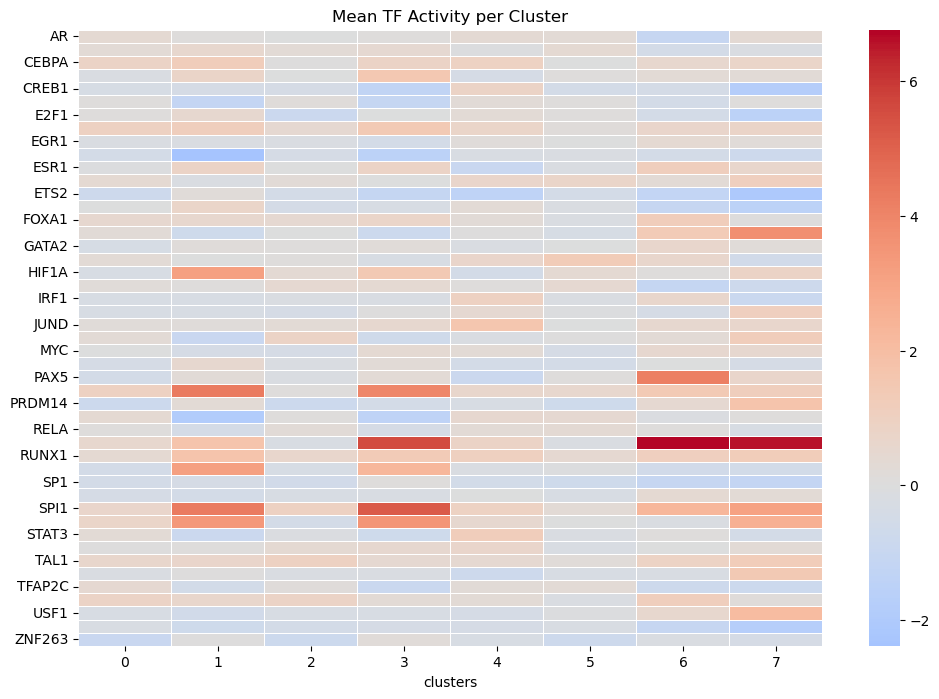

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the list of TFs that were scored
scored_tfs = adata.obsm['tf_activities'].columns.tolist()

# Build a dataframe of mean activity per cluster
cluster_avg_activity = (
    adata.obsm['tf_activities']
    .groupby(adata.obs['clusters'], observed=False)
    .mean()
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_avg_activity.T, # Transpose for TFs on y-axis, clusters on x-axis
    cmap='coolwarm',
    center=0,
    linewidths=.5
)
plt.title("Mean TF Activity per Cluster")
plt.show()

In [9]:
from scipy.stats import ttest_ind
import pandas as pd

results = []
# Compare cluster 0 and cluster 2
cluster1 = '0'
cluster2 = '2'

# Get cell barcodes for each cluster
cells_c1 = adata.obs_names[adata.obs.clusters == cluster1]
cells_c2 = adata.obs_names[adata.obs.clusters == cluster2]

# Loop through each TF, perform a t-test, and store the results
for tf in scored_tfs:
    activity_c1 = adata.obsm['tf_activities'].loc[cells_c1, tf]
    activity_c2 = adata.obsm['tf_activities'].loc[cells_c2, tf]
    
    stat, pval = ttest_ind(activity_c1, activity_c2)
    results.append({'TF': tf, 't_stat': stat, 'p_value': pval})

# Create a DataFrame and show the most significant TFs
diff_df = pd.DataFrame(results).sort_values(by='p_value').set_index('TF')

print(f"Top differentially active TFs between cluster {cluster1} and {cluster2}:")
print(diff_df.head(10))

Top differentially active TFs between cluster 0 and 2:
         t_stat       p_value
TF                           
STAT1  5.961577  2.960519e-08
E2F1   4.781952  5.323247e-06
CEBPA  4.199597  5.388125e-05
PPARG  4.160682  6.247191e-05
HIF1A -3.252245  1.513301e-03
STAT3  3.075483  2.641097e-03
E2F4   2.630392  9.728714e-03
RFX5   2.557629  1.187541e-02
ETS2  -2.494645  1.406750e-02
MITF  -2.455889  1.558997e-02


# 🔍 Interpretation of Transcription Factor Activities Across Clusters

Above is a **heatmap** of mean inferred TF activities for clusters 0–7, alongside a **table** of the top differentially active TFs between **cluster 0** and **cluster 2**.


| TF     | t-statistic | p-value        |
|:-------|------------:|---------------:|
| **STAT1** |     **5.96** | 2.96 × 10⁻⁸  |
| **E2F1**  |      4.78 | 5.32 × 10⁻⁶  |
| **CEBPA** |      4.20 | 5.39 × 10⁻⁵  |
| **PPARG** |      4.16 | 6.25 × 10⁻⁵  |
| HIF1A  |     –3.25 | 1.51 × 10⁻³  |
| STAT3  |      3.08 | 2.64 × 10⁻³  |
| E2F4   |      2.63 | 9.73 × 10⁻³  |
| RFX5   |      2.56 | 1.19 × 10⁻²  |
| ETS2   |     –2.49 | 1.41 × 10⁻²  |
| MITF   |     –2.46 | 1.56 × 10⁻²  |

---

## 🌐 Heatmap Highlights

- **Cluster 0** shows elevated activity of **STAT1**, **E2F1**, **CEBPA**, and **PPARG** (bright red), pointing to:
  - **STAT1**: interferon-driven activation or inflammatory signaling  
  - **E2F1**: active cell-cycle entry  
  - **CEBPA/PPARG**: myeloid differentiation programs  
- **Cluster 2** has comparatively lower activity of these same TFs (blue to neutral), suggesting a distinct functional state.

---

## 📊 Differential Activity Between Cluster 0 vs 2

- **STAT1** (t = 5.96, p ≈ 3 × 10⁻⁸) is the most significantly upregulated TF in cluster 0, indicating a strong interferon or immune-activation signature.  
- **E2F1** (t = 4.78) again underscores a proliferative bias in cluster 0 relative to cluster 2.  
- **HIF1A** shows **negative** t-stat (–3.25), meaning **higher** relative activity in cluster 2, implying cluster 2 may experience hypoxia-related or metabolic stress signaling.  
- **STAT3**, **E2F4**, **RFX5** also favor cluster 0, while **ETS2** and **MITF** lean toward cluster 2 (negative t-stats).

---

## 🧠 Biological Insights

1. **Cluster 0** appears to be a **pro-inflammatory, proliferative myeloid population**, with combined STAT1/STAT3 signaling and cell-cycle activation (E2F1).  
2. **Cluster 2** may represent a **stress-responsive or alternative lineage** with elevated HIF1A, ETS2, and MITF activity.  
3. The **balance** of these TF programs suggests functional specialization across clusters, guiding hypotheses for targeted validation (e.g., cytokine profiling or proliferation assays).

*This summary distills the key regulatory differences between clusters 0 and 2 and contextualizes them within known transcriptional programs.*  


<div style="
    border: 2px solid #333;
    background: #f9f9f9;
    padding: 16px 24px;
    margin: 20px 0;
    border-radius: 8px;
    font-family: sans-serif;
">
<h1 style="margin:0; color:#333; text-align:center; border-bottom: 2px solid #ccc; padding-bottom: 12px;">🔬 Project Conclusions & Summary 🔬</h1>
<p style="margin:16px 0 0 0;">
    This notebook successfully demonstrates an integrated, end-to-end single-cell transcriptomics workflow. By combining standard clustering with functional regulon analysis, we were able to move from simple cell type identification to a more nuanced understanding of cellular states.
    <br><br>
    The initial <b>Scanpy</b> pipeline effectively processed the raw count data, revealing distinct and well-defined clusters corresponding to major PBMC populations, including monocytes, B cells, NK cells, and T cells.
    <br><br>
    The subsequent functional analysis with <b>Decoupler</b> provided critical insights into the underlying regulatory programs. We successfully identified a key subpopulation of proliferative cells marked by high <b>E2F1</b> activity and distinguished it from cells in different activation states characterized by the <b>MAPK</b> pathway. Furthermore, differential analysis of transcription factor activities—such as the pro-inflammatory <b>STAT1</b> in monocytes versus the stress-responsive <b>HIF1A</b> in NK cells—highlighted the specialized biological roles of each cluster.
    <br><br>
    In summary, this combined approach provides a powerful framework for characterizing cellular heterogeneity, revealing not just "who" the cells are, but also "what" they are doing.
</p>
</div>